/home/myt8099/.conda/envs/bert/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


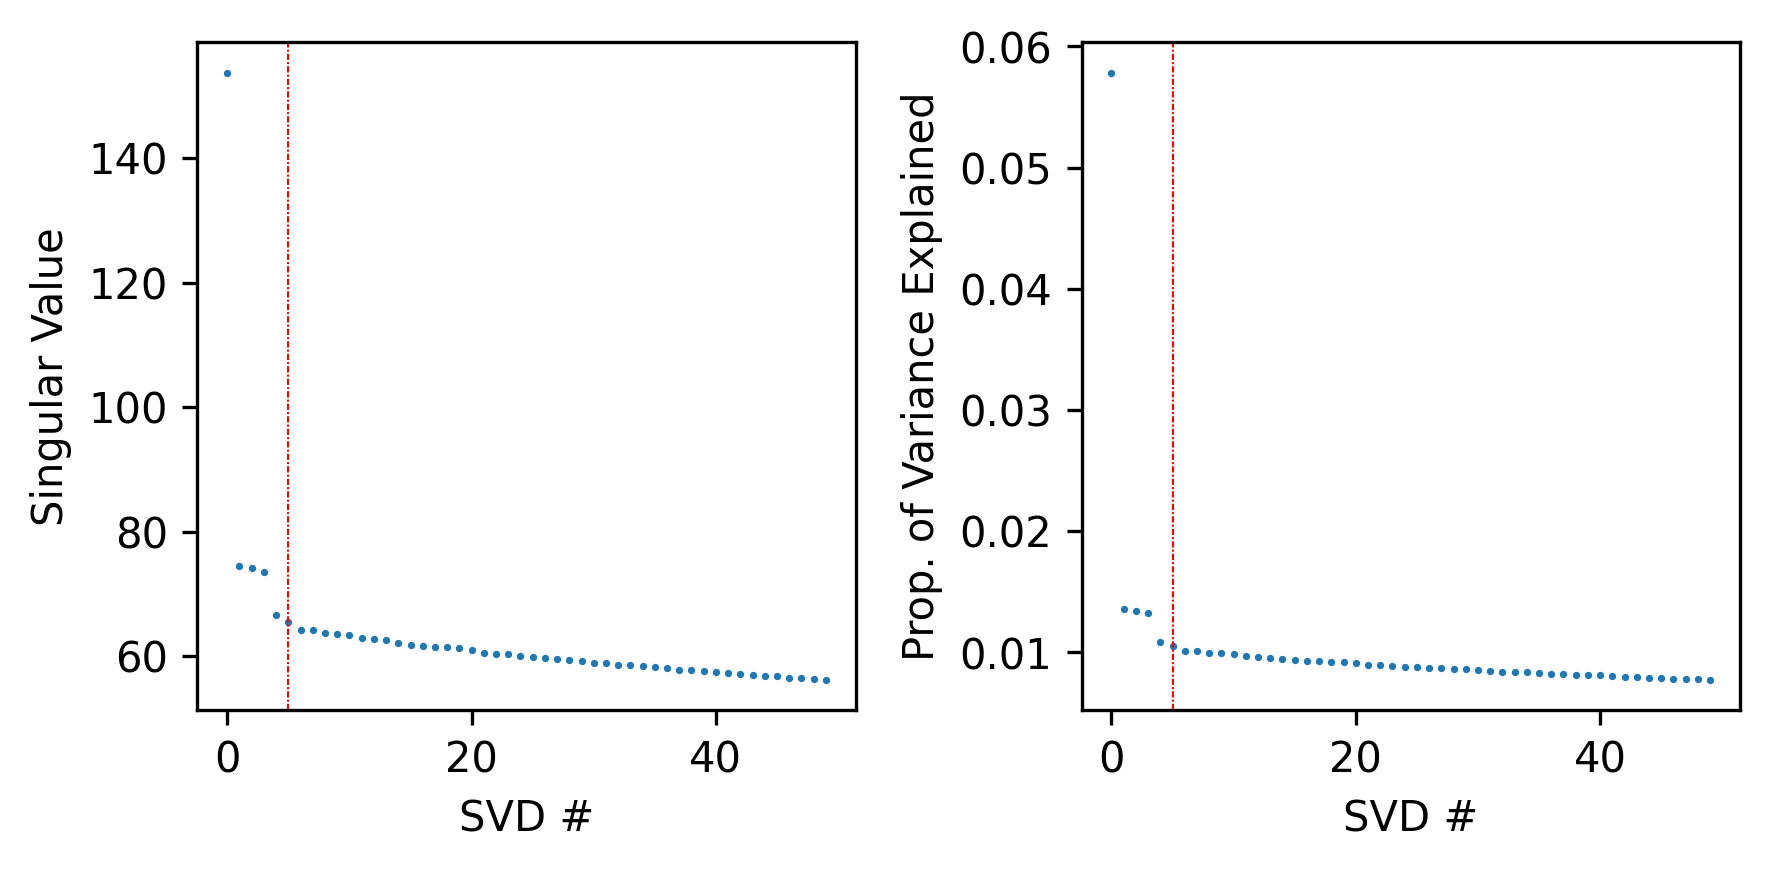

In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.spatial.distance import mahalanobis

sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW_v10.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("../../Downsampled_Data/*.hg38.frag.25pct.interval_mds.tsv", 0, 4)
z = hc_data.normalize_zscore()
_ = hc_data.merge_feature_metadata()
z = hc_data.batch_correct()

final_patient_df_combined = hc_data.get_raw_features()
final_patient_df_combined_metadata = hc_data.get_metadata_col("Treatment Response")
final_patient_df_combined = pd.concat([final_patient_df_combined, final_patient_df_combined_metadata], axis=1)

X_combined = final_patient_df_combined.iloc[:, :-1]
y_combined = final_patient_df_combined.iloc[:, -1]

y_combined = y_combined.astype(str)

X_combined['Treatment Response'] = y_combined
U, S, Vt = np.linalg.svd(X_combined.iloc[:, :-1], full_matrices=False)
prop_var_explained = (S**2) / np.sum(S**2)

plt.figure(figsize=(6, 3), dpi=300)

plt.subplot(1, 2, 1)
plt.plot(S[:50], 'o', markersize=0.75)
plt.xlabel("SVD #")
plt.ylabel("Singular Value")
plt.axvline(x=5, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=0.5)


plt.subplot(1, 2, 2)
plt.plot(prop_var_explained[:50], 'o', markersize=0.75)
plt.xlabel("SVD #")
plt.ylabel("Prop. of Variance Explained")
plt.axvline(x=5, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=0.5)

plt.tight_layout()
plt.savefig("R1C1_25pct.SVD.pdf")
plt.show()

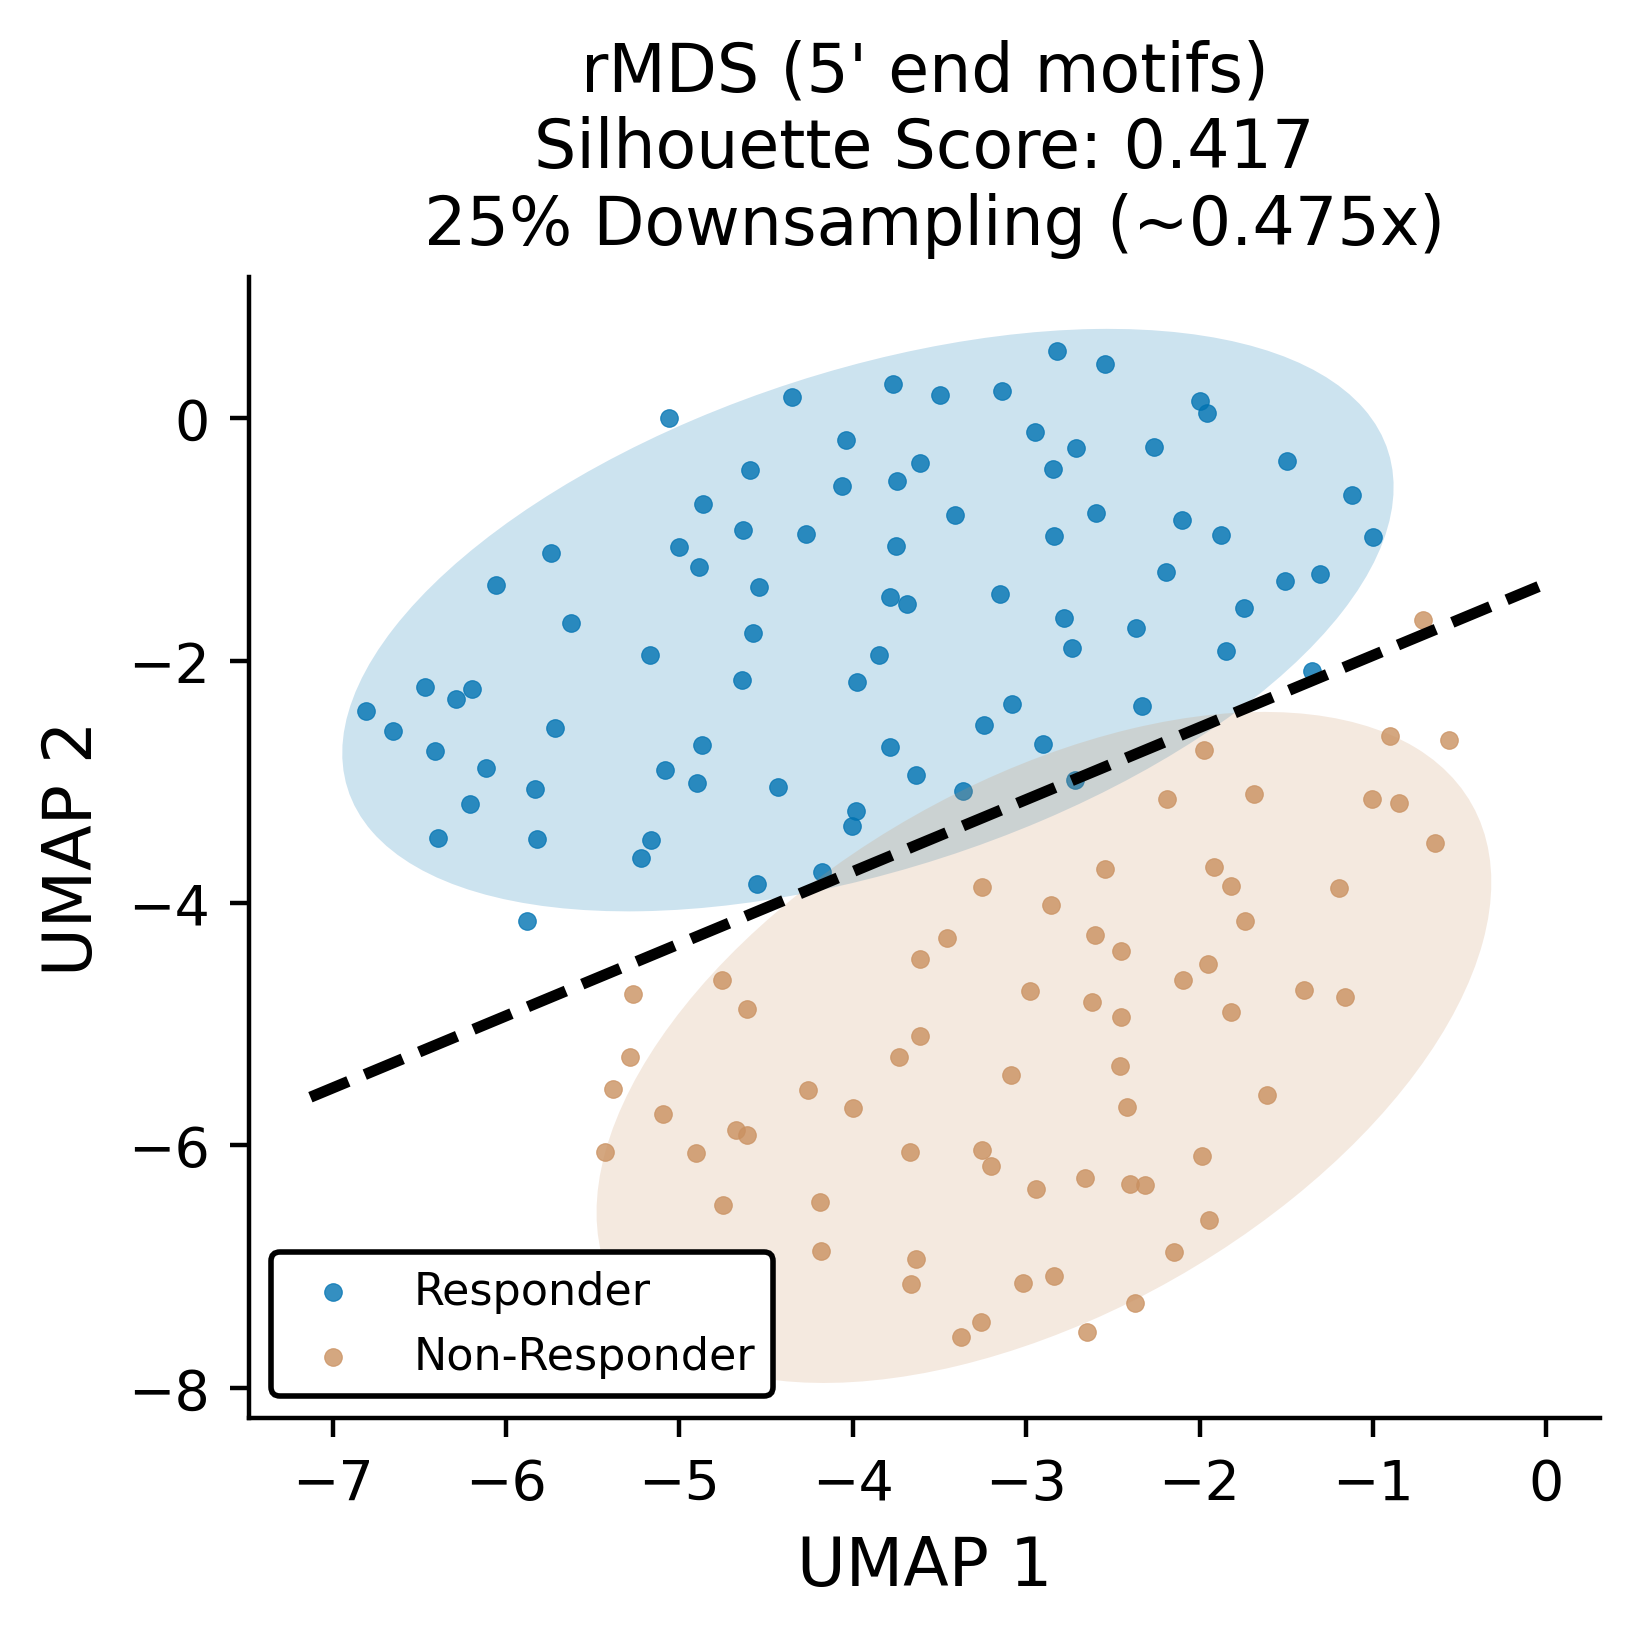

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from shapely.geometry import Point
from shapely.affinity import rotate, scale, translate
from shapely.geometry.polygon import Polygon
import umap
from sklearn.metrics import silhouette_score

umap_model = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.5, metric='cosine', random_state=42)
umap_result = umap_model.fit_transform(U[:, :6])

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=X_combined.index)
umap_df['Treatment Response'] = X_combined['Treatment Response']

score = silhouette_score(umap_df[['UMAP1', 'UMAP2']], umap_df['Treatment Response'])

unique_treatments = umap_df['Treatment Response'].unique()
colors = sns.color_palette('colorblind', 10)
selected_colors = [colors[5], colors[0]]
color_map = {treatment: selected_colors[i % len(selected_colors)] for i, treatment in enumerate(unique_treatments)}

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    if x.size <= 1:
        return
    cov = np.cov(x, y)
    if np.any(np.isnan(cov)) or np.linalg.det(cov) == 0:
        return
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * n_std * np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ellipse = Ellipse((np.mean(x), np.mean(y)), width=width, height=height,
                      angle=angle, facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)

def get_ellipse_polygon(x, y, width, height, angle_deg, num_points=200):
    circ = Point(0, 0).buffer(1, resolution=num_points)
    ell = scale(circ, width / 2.0, height / 2.0)
    ell = rotate(ell, angle_deg, origin=(0, 0))
    ell = translate(ell, x, y)
    return ell

fig, ax = plt.subplots(figsize=(4.2, 4.2), dpi=400)

ellipses = []
for treatment, color in reversed(list(color_map.items())):
    subset = umap_df[umap_df['Treatment Response'] == treatment]
    x, y = subset['UMAP1'].values, subset['UMAP2'].values
    ax.scatter(x, y, color=color, label=treatment, s=10, linewidth=0.2, alpha=0.8)
    confidence_ellipse(x, y, ax, n_std=2, facecolor=color, alpha=0.2, edgecolor='none')

    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * 2 * np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    center_x, center_y = np.mean(x), np.mean(y)
    ellipses.append(get_ellipse_polygon(center_x, center_y, width, height, angle))

intersection = ellipses[0].intersection(ellipses[1])
points=[]
if not intersection.is_empty:
    if intersection.geom_type == 'Polygon':
        coords = np.array(intersection.exterior.coords)
        max_dist = 0
        farthest_pair = (coords[0], coords[1])
        for p1, p2 in combinations(coords, 2):
            dist = np.linalg.norm(np.array(p1) - np.array(p2))
            if dist > max_dist:
                max_dist = dist
                farthest_pair = (p1, p2)
        points = [Point(farthest_pair[0]), Point(farthest_pair[1])]
    elif intersection.geom_type == 'MultiPoint':
        points = list(intersection)
    elif intersection.geom_type == 'GeometryCollection':
        points = [geom for geom in intersection.geoms if geom.geom_type == 'Point']
    elif intersection.geom_type == 'Point':
        points = [intersection]

if len(points) >= 2:
    p1, p2 = points[:2]
    x_vals = np.array(ax.get_xlim())
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    if dx != 0:
        slope = dy / dx
        intercept = p1.y - slope * p1.x
        y_vals = slope * x_vals + intercept
    else:
        x_vals = [p1.x, p1.x]
        y_vals = ax.get_ylim()
    ax.plot(x_vals, y_vals, linestyle='--', color='black', linewidth=2)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.legend(loc='lower left', fontsize=8, frameon=True, edgecolor='black', facecolor='white', framealpha=1)
sns.despine()
plt.title(f"rMDS (5' end motifs)\nSilhouette Score: {score:.3f}\n 25% Downsampling (~0.475x)")
plt.tight_layout()
plt.savefig("R1C1_25pct.UMAP.pdf", dpi=600)